# Functional API in Keras

## 1: 切換 TensorFlow 版本及匯入所需套件

In [ ]:
%tensorflow_version 2.x

In [2]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np

# Layers for FNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Layers for CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, Adam

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 2: 下載並整理 Fashion MNIST 資料集

In [4]:
# Load Fashine MNIST
(X_train, y_train0), (X_test, y_test0) = datasets.fashion_mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

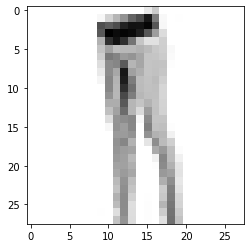

In [5]:
idx = np.random.randint(X_train.shape[0])
sample = X_train[idx]
plt.imshow(sample.reshape(28,28),'Greys')

## 3: 寫起來像寫數學函數的 Functional API

在此之前，我們使用 Sequential 便足以建構大多數的神經網路，那是因為我們接觸的神經網路多為線性堆疊 (linear stack)。

除了輸入層需指定 `input_dim` 外，其餘隱藏層只需宣告，那是因為 Sequential 會認定上一層的輸出這一層的輸入。

因此，再建構線性堆疊的神經網路時，Sequential 便足以處理。

### 3.1 Functional API 的使用時機

當神經網路模型為非線性的複雜網路結構，如：

* 多重輸出-多重輸入模型 (Multi-input and multi-output models)
  + 分歧 (branch)
  + 合併 (merge)
* 具重複/循環結構的模型，如: CycleGAN

Sequential 便不足以建構這類複雜結構的神經網路，我們以下介紹 `Model` Fnuctional API 的使用。

在 `Model` 的世界中，所有的神經網路層 (全連接, 卷積, 池化, RNN等) 都將視作函數來定義，因此，我們只需關心函數的輸入和輸出即可。

此外，為了讓神經網路的第一層從不需要輸入 `input_dim`，我們還需引進下面這個函數來代替 `input_dim`。 (此寫法亦可用在 `Sequential`)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

### 3.2 Functional API 的函數概念

回顧一下，我們想學習的手寫辨識模型是一個長得像這樣的函數

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

我們希望建立一個具有兩個隱藏層的神經網路來學習這個函數，攤開來看的話，如下：

$$\mathbb{R}^{784} \overset{f_1}{\to} \mathbb{R}^{500} \overset{f_2}{\to} \mathbb{R}^{500} \overset{f_3}{\to} \mathbb{R}^{10}$$

$$x \overset{f_1}{\mapsto} h_1 \overset{f_2}{\mapsto} h_2 \overset{f_3}{\mapsto} y$$


或是以簡易的圖來表示這個全連接神經網路


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1jy23j3kto7f1RHzGSav_8PyM9J5cMlCg", width="40%"
   />
</p>

其中，$f_1, f_2, f_3$ 代表的是全連結層所代表的函數，其他變數說明如下：

* $x$: 代表的是輸入模型的圖片向量，為 784 維的向量。
* $h_1$: $x$ 經過第一層隱藏層運算後得結果，即為 $f_1(x)$，為 500 維的向量。
* $h_2$: $h_1$ 經過第二層隱藏層運算後得結果，即為 $f_2(h_1)$，為 500 維的向量。
* $y$: $h_2$ 經過最後一層運算後得結果，即為 $f_3(h_2)$，為 10 維的向量，代表的是 $x$ 為哪個數字的機率。

注意: 為了方便，我們將 `Dense(500)`, `Activation('sigmoid')` 兩個合併用 `Dense(500, activation='sigmoid')` 表示

### 3.3 Functional API 的操作方式

我們沿用上圖的變數名稱來定義

In [23]:
f_1 = Dense(500, activation='sigmoid')
f_2 = Dense(500, activation='sigmoid')
f_3 = Dense(10, activation='softmax')

In [24]:
print(f_1)

接著，定義層前後變數之間的關係；首先，第一個變數必定以 `Input` 函數來定義

In [25]:
x = Input(shape=(784,))

In [26]:
print(x)

Tensor("input_4:0", shape=(None, 784), dtype=float32)


剩下的部分，就如變數說明，**幾乎**可以照著數學式輸入 $$h_1 = f_1(x), h_2 = f_2(h_1), y = f_3(h_2)$$

In [27]:
h_1 = f_1(x)
h_2 = f_2(h_1)
y = f_3(h_2)

In [28]:
print(y)

Tensor("dense_8/Identity:0", shape=(None, 10), dtype=float32)


在這裡，變數 $h_1, h_2, y$ 是以張量 (tensor) 類別來表示，我們可以嘗試 `print` 看看。

In [29]:
print(h_1)
print(h_2)
print(y)

Tensor("dense_6/Identity:0", shape=(None, 500), dtype=float32)
Tensor("dense_7/Identity:0", shape=(None, 500), dtype=float32)
Tensor("dense_8/Identity:0", shape=(None, 10), dtype=float32)


接著，透過 `Model` 將一個模型的輸入/輸出包裝起來，建立模型的過程就完成了！

In [30]:
model = Model(x, y)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [31]:
model.compile(loss='mse', 
              optimizer=Adam(), 
              metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train, 
          batch_size=256, 
          epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0355 - accuracy: 0.7451
Epoch 2/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0228 - accuracy: 0.8411
Epoch 3/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0206 - accuracy: 0.8577
Epoch 4/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0193 - accuracy: 0.8666
Epoch 5/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0186 - accuracy: 0.8727


雖然 summary 少了很多東西，但模型架構和之前做的沒有差異，所以可以安心讀入之前訓練好的權重。

In [33]:
model.save_weights('MNIST_Model.h5')

In [34]:
score = model.evaluate(X_train, y_train, batch_size=10000)
print(f'Loss: {score[0]}')
print(f'準確率: {score[1]*100}')

60000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Loss: 0.017566698603332043
準確率: 88.00166845321655


### 3.4 小結論
Functional API 的操作流程如下：
1. 將層定義成明確的函數
2. 透過層函數將變數連接
3. 定義神經網路的輸入與輸出

## 4: 非線性堆疊模型

### 4.1 如何建立具分歧及合併結構的神經網路模型呢？

In [35]:
from tensorflow.keras.layers import concatenate, add

首先，假設我們希望在模型之間增加一個分歧，且這個分歧在模型的輸出會合併，則神經網路的結構會變成：

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1PltMM0qQFRxA_RS_9X9jz04HmTvDzLS6", width="40%"
   />
</p>

此模型為單一輸入、多重輸出的模型，是分歧模型最容易處理的一種。

其中，$f_1, f_2$ 同之前，$f_4:\mathbb{R}^{500}\to\mathbb{R}^{500}$ 的全連接層，但 `Activation` 改用 `ReLu`。

需注意的是，由於 $f_3$ 的定義域改變，為 $\mathbb{R}^{500}\times\mathbb{R}^{500}\to\mathbb{R}^{10}$ 函數，所以需要重新定義。

* $x$: 代表的是輸入模型的圖片向量，為 784 維的向量。
* $h_1$: $x$ 經過 $f_1$ 隱藏層運算後得結果，即為 $f_1(x)$，為 500 維的向量。
* $h_2$: $h_1$ 經過 $f_2$ 隱藏層運算後得結果，即為 $f_2(h_1)$，為 500 維的向量。

* $z$: $h_1$ 經過 $f_4$ 運算後得結果，即為 $f_4(h_1)$，為 500 維的向量。
* $y$: $h_2$ 和 $z$ 經過新的 $f_3$ 運算後得結果，即為 $f_3(h_2, z)$，為 10 維的向量，代表的是 $x$ 為哪個數字的機率。

因為上面已將 $f_4$ 及 $z$ 以外的變數定義好，我們只需定義 $f_3$, $f_4$ 及 $z$ 即可

In [41]:
f_4 = Dense(500, activation='relu')
z = f_4(h_1)

# new f_3
f_3 = Dense(10, activation='softmax')

In [42]:
x =Input(shape=(784,))

h_1 = f_1(x)
h_2 = f_2(h_1)
z = f_4(h_1)

接著，再將 $y = f_3(h_2, z)$ 定義好，就會發現......

In [ ]:
# 此段程式碼為錯誤範例
y = f_3(h_2, z)

TypeError: ignored

聰明的你/妳，可能會想到，函數的寫法是一次送進一個變數，那我們將 $h_3$ 和 $z$ 寫成 `list` 的形式，應該就可以送進去 $f_3$ 了吧？

In [ ]:
# 此段程式碼為錯誤範例
y = f_3([h_2, z])

ValueError: ignored

會發現這樣也沒辦法成功。其實正確的作法是，先將 $h_2$ 與 $z$ 透過 `concatenate` 接在一起，再送進新的 $f_3$ 裡。

在這裡，我們將 $h_2$ 與 $z$ `concatenate` 接在一起，稱做 $u$。

In [37]:
# new f_3
f_3 = Dense(10, activation='softmax')

u = concatenate([h_2, z])
y = f_3(u)

In [38]:
print(u)
print(y)

Tensor("concatenate/Identity:0", shape=(None, 1000), dtype=float32)
Tensor("dense_11/Identity:0", shape=(None, 10), dtype=float32)


換句話說，模型其實是這樣畫的

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1pvzH_552VmyLoKwTayjy0_dVNvEpHol2", width="40%"
   />
</p>

其中，`concatenate` 是將不同的變數**接**在一起，這裡面並沒有進行任何涉及權重的運算。

再透過 `Model` 將模型的輸入和輸出包裝起來，即可將模型建構完成。

In [39]:
model = Model(x, y)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 500)          392500      input_4[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 500)          250500      dense_6[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 500)          250500      dense_6[0][0]                    
____________________________________________________________________________________________

### 4.2 應用情境
Branch-and-Merge 的注意要點如下：
1. 每一層分別定義成函數
2. 分歧結構: 實就是透過新的函數來定義新的變數，無特別注意事項。
3. 合併結構: 要合併前，將所有要進入的變數都合併起來，才能進行之後的運算。

常見應用:
1. 多重輸入-多重輸出模型。
2. 當層函數為 convolution 時，這樣的技巧可以實現 U-net 上的重要結構 multi-resolution fusion (多解析度融合，又稱 MRF)。
3. ResNet 上的重要結構 skip connection (跳躍式傳遞)，亦可透過分歧-合併來實現，只是 ResNet 使用的是 `add` 而非 `concatenate`。

#### a) 多重輸入模型

In [45]:
# 以 ResNet 中的 skip connection 為例
input_a = Input(shape=(784,))
input_b = Input(shape=(256,))

f_a = Dense(256, activation='sigmoid')

output_ab = add([f_a(input_a), input_b])

multi_input = Model([input_a, input_b], output_ab)
multi_input.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          200960      input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
add (Add)                       (None, 256)          0           dense_16[0][0]                   
                                                                 input_8[0][0]              

In [46]:
print(f'Input shape: {multi_input.input_shape}')
print(f'Output shape: {multi_input.output_shape}')

Input shape: [(None, 784), (None, 256)]
Output shape: (None, 256)


#### b) 多重輸出模型

In [47]:
input_a = Input(shape=(784,))

multi_output = Model(input_a, [f_a(input_a), input_a])
multi_output.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               200960    
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________


In [48]:
print(f'Input shape: {multi_output.input_shape}')
print(f'Output shape: {multi_output.output_shape}')
# x -> [f(x), x]

Input shape: (None, 784)
Output shape: [(None, 256), (None, 784)]


#### c) 串接模型

In [49]:
# 模型 a
input_a = Input(shape=(256,))
g_a = Dense(128, activation='relu')
output_a = g_a(input_a)

model_a = Model(input_a, output_a)
model_a.summary()

# 模型 b
input_b = Input(shape=(128,))
g_b = Dense(20, activation='relu')
output_b = g_b(input_b)

model_b = Model(input_b, output_b)
model_b.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
Total params: 32,896
Trainable params: 32,896
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
Total params: 2,580
Trainable params: 2,580
Non-trainable params: 0
_________________________________________________________________


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1UEgulqcuY4cPeYJ_W1etafFl-Y1DMV_r", width="80%"
   />
</p>

In [50]:
big_model = Model(input_a, g_b(output_a))
big_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
Total params: 35,476
Trainable params: 35,476
Non-trainable params: 0
_________________________________________________________________


In [51]:
big_model_2 = Model(model_a.input, g_b(model_a.output))
big_model_2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
Total params: 35,476
Trainable params: 35,476
Non-trainable params: 0
_________________________________________________________________


### 4.3 自定義的不具可訓練權重之神經網路層
這裡，我們將進行這單元最後一個重要的神經網路建構技巧 - 自定義神經網路層 (不具可訓練權重)

** 具有可訓練重的自定義層牽扯到 TensorFlow 及 Python 類別的撰寫，若有興趣可參考: https://keras.io/layers/writing-your-own-keras-layers/

首先，我們需要引入 `Lambda` 這個函數，透過 `Lambda` 函數，我們可以將 Python 上的 function，包裝成 Keras 上的 layer。

此外，我們需要引進後端所使用的套件 (此處為 TensorFlow)，並使用裡面的運算進行 function 的撰寫。

In [52]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

首先，我們透過 backend 來定義一個簡單的 function，作用是對輸入取平均，程式碼如下：

In [53]:
def average_function(inputs):
    return K.mean(inputs, axis=1)

接著，我們將一個 numpy array 送進這個函式，看看會發生什麼事。

In [ ]:
# 此段程式碼為錯誤範例
average_function(np.array([1, 3]))

AttributeError: ignored

你/妳會發現，這邊的函式不接受 numpy array 的類型作為輸入，這是因為 TensorFlow 有自定義的類型，因此，在這邊我們沒辦法直接使用這個函式。

我們透過 `Lambda` ，將上述函式包裝成一個神經網路層。

In [54]:
average_layer = Lambda(average_function)

In [55]:
print(average_layer)

此時，下述程式碼可以建構出一個將指定長度的資料取平均的神經網路。

In [56]:
inputSize = 4

x = Input(shape=(inputSize,))
y = average_layer(x)
average_model = Model(x, y)

可以發現，這樣的神經網路是不具有訓練權重的。

In [57]:
average_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
lambda (Lambda)              (None,)                   0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


記得，在使用前記得先 compile

In [ ]:
average_model.compile(loss='mse', optimizer='sgd')

接著，我們將 `[1, 2, 3, 4]` 送進這個神經網路，看看神經網路的輸出是否為這個向量的**平均。

In [ ]:
p = np.array([[1, 2, 3, 4]])
average_model.predict(p)

array([2.5], dtype=float32)

可以發現，將 `[1, 2, 3, 4]` 轉成 Numpy array 送進神經網路**預測**後，答案是 `2.5`，即為 (1+2+3+4)/4，確實是平均。

我們也可以一次送進多筆資料進行平均的計算。

In [ ]:
q = np.array([[1, 2, 3, 4],
              [1, 1, 1, 1]])
average_model.predict(q)

array([2.5, 1. ], dtype=float32)

### 加碼: 具抽樣功能的神經網路層

輸入為 $(\mu, s)$ ，$\mu=(\mu_1,\cdots,\mu_n)$ 和 $s=(s_1,\cdots,s_n)$ 各自為 $n$ 維向量。

我們希望神經網路層輸出為服從 $N(\mu, e^{s}I_n)$ 的 $n$ 維向量，換言之，我們希望建構的神經網路其實是一個抽樣函數。

** 由於神經網路的輸入輸出經常沒有限制，為了讓 $s$ 具有變異數的非負特性，我們考慮 $e^{s}$ 作為變異數；換言之，$s$ 為 log-variance。

假設我們想進行抽樣的維度為 `sampling_dim`，則一個具抽樣函數功能的神經網路可由下述方式建構。

In [ ]:
sampling_dim = 2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(sampling_dim,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

這裡使用到常態分配的線性特性來定義函數，亦即

$$X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$$


若不熟機率論的同學，可以詢問助教。

In [ ]:
sample_layer = Lambda(sampling, output_shape=(sampling_dim,))

In [ ]:
m = Input(shape=(sampling_dim,))
s = Input(shape=(sampling_dim,))

z = sample_layer([m, s])

sample_model = Model([m, s], z)

In [ ]:
sample_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
test_mean = np.random.randint(10, size=sampling_dim).reshape(1, 2)
test_log_var = np.array([[0, 0]])

print(f'平均為 {test_mean[0][0]}, {test_mean[0][1]}')

平均為 2, 8


透過下面的指令，我們每次可以抽樣出一服從上述要求常態分配之隨機向量

In [ ]:
sample_model.predict([test_mean, test_log_var])

array([[1.7366369, 6.8897314]], dtype=float32)

來和 Numpy 上的抽樣函數進行比較吧~

In [ ]:
num_of_samples = 100

In [ ]:
np_sample = np.random.multivariate_normal(test_mean[0], np.identity(2), size=num_of_samples)

In [ ]:
kears_sample = np.zeros((num_of_samples, 2))
for i in range(num_of_samples):
    kears_sample[i] = sample_model.predict([test_mean, test_log_var])

Text(0.5, 1.0, 'Normal Random Samples using Keras/Numpy')

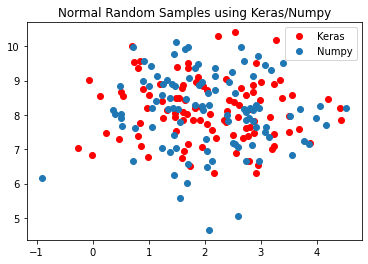

In [ ]:
plt.plot(kears_sample[:, 0], kears_sample[:, 1], 'ro')
plt.plot(np_sample[:, 0], np_sample[:, 1], 'o')
plt.legend(['Keras', 'Numpy'])
plt.title('Normal Random Samples using Keras/Numpy')

## 恭喜你，完成所有建立 Variational Autoencoder 所需的重要技巧。

Variational Autoencoder (VAE) 是一個重要的非監督式學習模型，具體應用的場合為特徵抽取/資料壓縮及還原，為影像處理中常見的模型之一。

在建立 VAE中，需要三個重要技巧:
* 分歧-合併
* 自定義函數 (抽樣函數)
* 自定義損失函數

雖然不知道之後課程會不會用到，但多學點總是好的 : )